In [198]:
%pip install nltk
%pip install scikit-fuzzy
import pandas as pd
import re
import nltk
import os
import numpy as np
import skfuzzy as fuzz
import time
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()


pd.set_option('display.max_colwidth', 1000)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [199]:
def remove_urla(row):
    text = row['sentence']
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove letras repetidas sin sentido
    text = re.sub(r'(.)\1{2,}', r'\1', text, flags=re.MULTILINE)
    # Remove '@' symbols
    text = text.replace('@', '')
    return text

def expand_contractions(row):
    text = row['clean_sentence']
    contractions_dict = {
        "can t ": "can not ",
        "won t ": "will not ",
        "n t ": " not ",
        " re ": " are ",
        " s ": " is ",
        " d ": " would ",
        " ll ": " will ",
        " t ": " not ",
        " ve ": " have ",
        " m ": " am "
    }
    
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]

    return contractions_re.sub(replace, text)

def lexicon(row):
    # Se aplica Vader
    start = time.time()
    text = row['sentence']
    scores = vader.polarity_scores(text)
    spent = time.time() - start
    
    return pd.Series([scores['neg'], scores['pos'], spent])

x_p = np.arange(0, 1, 0.1)
x_n = np.arange(0, 1, 0.1)
x_op = np.arange(0, 10, 1)

def fuzzier(row):
    start = time.time()
    negativo = row['negativo']
    positivo = row['positivo']

    low_grado_positivo = fuzz.interp_membership(x_p, pos_low, positivo)
    mid_grado_positivo = fuzz.interp_membership(x_p, pos_mid, positivo)
    high_grado_positivo = fuzz.interp_membership(x_p, pos_high, positivo)
    
    low_grado_negativo = fuzz.interp_membership(x_n, neg_low, negativo)
    mid_grado_negativo = fuzz.interp_membership(x_n, neg_mid, negativo)
    high_grado_negativo = fuzz.interp_membership(x_n, neg_high, negativo)
    spent = row['tiempo'] + time.time() - start

    return pd.Series([low_grado_positivo, mid_grado_positivo, high_grado_positivo, low_grado_negativo, mid_grado_negativo, high_grado_negativo, spent])

def ruler(row):
    start = time.time()
    res = pd.Series([
        np.fmin(row['low_grado_positivo'],row['low_grado_negativo']), #r1
        np.fmin(row['mid_grado_positivo'],row['low_grado_negativo']), #r2
        np.fmin(row['high_grado_positivo'],row['low_grado_negativo']), #r3
        np.fmin(row['low_grado_positivo'],row['mid_grado_negativo']), #r4
        np.fmin(row['mid_grado_positivo'],row['mid_grado_negativo']), #r5
        np.fmin(row['high_grado_positivo'],row['mid_grado_negativo']), #r6
        np.fmin(row['low_grado_positivo'],row['high_grado_negativo']), #r7
        np.fmin(row['mid_grado_positivo'],row['high_grado_negativo']), #r8
        np.fmin(row['high_grado_positivo'],row['high_grado_negativo']), #r9
        row['tiempo'] + time.time() - start
    ])
    
    return res

def aggregator(row):
    start = time.time()
    wneg = np.fmax(row['r4'], np.fmax(row['r7'], row['r8']))
    wpos = np.fmax(row['r1'], np.fmax(row['r5'], row['r9']))
    wmid = np.fmax(row['r2'], np.fmax(row['r3'], row['r6']))

    op_activation_low = np.fmin(wneg, op_neg)
    op_activation_mid = np.fmin(wmid, op_mid)
    op_activation_high = np.fmin(wpos, op_pos)

    aggregated = np.fmax(op_activation_low, np.fmax(op_activation_mid, op_activation_high))
    spent = row['tiempo'] + time.time() - start

    return pd.Series([wneg, wpos, wmid, op_activation_low, op_activation_mid, op_activation_high, aggregated, spent])

def defuzzier(row):
    start = time.time()
    coa = fuzz.defuzz(x_op, row['aggregated'], 'centroid')

    defuzz_class = 'Negativo'
    if coa > 3.3 and coa < 6.7:
        defuzz_class = 'Neutral'
    elif coa > 6.7 and coa < 10:
        defuzz_class = 'Positive'

    spent = row['tiempo'] + time.time() - start

    return pd.Series([coa, defuzz_class, spent])

In [200]:
df = pd.read_csv('test_data.csv')

### Text Pre-processing

In [201]:
df['clean_sentence'] = df.apply(remove_urla, axis=1)
df['clean_sentence'] = df.apply(expand_contractions, axis=1)

#### Lexicón de Sentimientos

In [202]:
# lexicon call
df[['negativo', 'positivo', 'tiempo']]=df.apply(lexicon, axis=1)

#### Fuzzificación

In [203]:
neg_min = df['negativo'].min()
neg_max = df['negativo'].max()
pos_min = df['positivo'].min()
pos_max = df['positivo'].max()
neg_mid_val = (neg_max + neg_min)/2
pos_mid_val = (pos_max + pos_min)/2
pos_low = fuzz.trimf(x_p, [pos_min, pos_min, pos_mid_val])
pos_mid = fuzz.trimf(x_p, [pos_min, pos_mid_val, pos_max])
pos_high = fuzz.trimf(x_p, [pos_mid_val, pos_max, pos_max])
neg_low = fuzz.trimf(x_n, [neg_min, neg_min, neg_mid_val])
neg_mid = fuzz.trimf(x_p, [neg_min, neg_mid_val, neg_max])
neg_high = fuzz.trimf(x_p, [neg_mid_val, neg_max, neg_max])
op_neg = fuzz.trimf(x_op, [0, 0, 5])
op_mid = fuzz.trimf(x_op, [0, 5, 10])
op_pos = fuzz.trimf(x_op, [5, 10, 10])

# fuzzier call
df[['low_grado_positivo', 'mid_grado_positivo', 'high_grado_positivo', 'low_grado_negativo', 'mid_grado_negativo', 'high_grado_negativo', 'tiempo']]=df.apply(fuzzier, axis=1)

#### Base de reglas

In [204]:
# ruler call
df[['r1','r2','r3','r4','r5','r6','r7','r8','r9', 'tiempo']] = df.apply(ruler, axis=1)

In [205]:
# aggregator call
df[['wneg', 'wpos', 'wmid', 'op_activation_low', 'op_activation_mid', 'op_activation_high', 'aggregated', 'tiempo']] = df.apply(aggregator, axis=1)

#### Defuzzificacion

In [206]:
# deffuzzier call
df[['defuzz_coa', 'defuzz_class', 'tiempo']] = df.apply(defuzzier, axis=1)

In [207]:
# Show auxiliar result
df[['sentiment', 'defuzz_class', 'defuzz_coa', 'clean_sentence', 'tiempo']].head(25)

,sentiment,defuzz_class,defuzz_coa,clean_sentence,tiempo
0,1,Neutral,4.910571,i love my kindle not that the dx is cool but the is fantastic in its own right,0.000685
1,1,Neutral,4.908400,reading my kindle love it lee childs is good read,0.000386
2,1,Neutral,5.062744,ok first assesment of the kindle it fucking rocks,0.000269
3,1,Neutral,4.797403,you will love your kindle i have had mine for a few months and never looked back the new big one is huge no need for remorse,0.000410
4,1,Neutral,4.909013,fair enough but i have the kindle and i think it is perfect,0.000270
5,1,Neutral,4.723839,no it is too big i am quite happy with the kindle,0.000253
6,0,Negativo,1.905230,fuck this economy i hate aig and their non loan given asses,0.000273
7,1,Neutral,4.894804,jquery is my new best friend,0.000234
8,1,Neutral,4.910616,loves twitter,0.000250
9,1,Neutral,4.215632,how can you not love obama he makes jokes about himself,0.000323


In [208]:
new_colnames = ['Oracion original', 'Label Original', 'Puntaje negativo', 'Puntaje positivo', 'Inferencia', 'Tiempo de ejecucion']
result_df = df[['sentence', 'sentiment', 'negativo', 'positivo', 'defuzz_class', 'tiempo']]
result_df.columns = new_colnames
result_df.to_csv('results.csv', index=False)

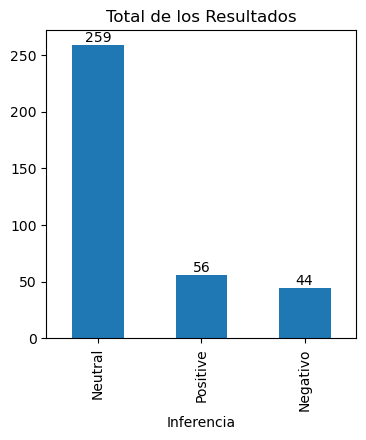

In [209]:
counts = result_df['Inferencia'].value_counts()
counts.plot.bar()
ax = counts.plot(kind='bar', figsize=(4, 4))

# Add value labels on top of bars
for i, value in enumerate(counts):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')
    
plt.title('Total de los Resultados')
plt.show()

#### Total de tiempo por clase en segundos

In [210]:
time_sum = result_df.groupby('Inferencia')['Tiempo de ejecucion'].sum()
time_sum

Inferencia
Negativo    0.009392
Neutral     0.068382
Positive    0.010867
Name: Tiempo de ejecucion, dtype: float64

#### Promedio de tiempo por clase en segundos

In [211]:
time_sum / counts

Inferencia
Negativo    0.000213
Neutral     0.000264
Positive    0.000194
dtype: float64